<a href="https://colab.research.google.com/github/mefonseca/Insurance_payment/blob/main/Non_payment_of_insurance_premium.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In this notebook, I will analyze the "Health Insurance Premium of Customers" dataset [1] to predict whether a customer will pay the next premium or not. In addition to the prediction, my goal is to also understand the most important factors that explain non-payment. 

Here are the main steps (adapted from [2]) this Data Science project will encompass, including problem definition, exploratory analysis, modeling, evaluation, and deployment:

1. Problem Definition
    - 1.1 Definition of insurance technical terms
    - 1.2 Goals
    - 1.3 Dataset
2. Feature Engineering
    - 2.1 Exploratory Analysis
    - Feature Extraction
    - Missing Values Imputation
    - Feature Encoding
    - Feature Selection – Dimensionality Reduction
3. Predictive Modelling
    - Evaluation Metric Selection
    - Cross-Validation Set-up
    - Algorithmic Approach
    - ML Algorithm Selection – Hyper-parameter Tuning
4. Model Deployment

**Author:** Maria Eugênia F. da Fonseca (fonsecamef@gmail.com)

**Date:** April 2021

# 1. Problem Definition

## 1.1. Definition of insurance technical terms
Before defining the problem and diving into the data analysis, it is extremely important to clarify some terms within the insurance sphere (adapted from [3]).

* **Insurance**: Something people buy to protect themselves from losing money in the event of an accident or unexpected mishap. It’s an agreement between you (the person being insured), and your insurance company, where you’ll pay a certain amount up front — your premium. In the event of an accident, injury, or other loss covered in your policy, you’ll pay a small portion of the financial cost, known as the “deductible,” and the insurance company promises to pay above that amount up to the limit shown on their policy.
* **Policy**: A formal written contract of insurance. 
Policyholder: The person who applied for, pays for, and is issued the insurance policy.
* **Premium**: The amount of money an insurance company charges to provide coverage.
* **Claim**: An insurance claim is when you request your insurance company to pay you after a loss. If your insurance company validates the claim, you’ll be issued payment.

## 1.2. Goals
As you can imagine, if a large number of customers do not pay the premium on time, it might disrupt the cash flow and smooth operation for the company [1]. A model that predicts whether a customer would make the premium payment can be extremely helpful for the company because, for example, it can then accordingly plan its communication strategy to reach out to those customers who are less likely to pay and convince them to continue making timely payments [1]. Having said that, the goals of this project are:
* Build a model to predict whether a customer will pay the next premium or not. 
* Understand the most important factors that explain non-payment.

## 1.3. Dataset
To conduct this analysis I will use the "Health Insurance Premium of Customers" dataset available on Kagle [1]. In this dataset, we have information about past premium payment history along with information such as demographics (age, monthly income, area type) and sourcing channel.

# 2. Feature Engineering

## 2.1 Exploratory Analysis

Firstly, let's import the dataset. On its page on Kagle, there are two files: a train and a test dataset.

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Portfolio de projetos/Non-payment of insurance premium/train_jRxnrHD.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Portfolio de projetos/Non-payment of insurance premium/test_QaJU1Mh.csv')

In [ ]:
train.dtypes

id                                    int64
perc_premium_paid_by_cash_credit    float64
age_in_days                           int64
Income                                int64
Count_3-6_months_late               float64
Count_6-12_months_late              float64
Count_more_than_12_months_late      float64
application_underwriting_score      float64
no_of_premiums_paid                   int64
sourcing_channel                     object
residence_area_type                  object
premium                               int64
target                                int64
dtype: object

In [ ]:
test.dtypes

id                                    int64
perc_premium_paid_by_cash_credit    float64
age_in_days                           int64
Income                                int64
Count_3-6_months_late               float64
Count_6-12_months_late              float64
Count_more_than_12_months_late      float64
application_underwriting_score      float64
no_of_premiums_paid                   int64
sourcing_channel                     object
residence_area_type                  object
dtype: object

In [ ]:
print('Train dataset shape:', train.shape)
print('Test  dataset shape:', test.shape)

Train dataset shape: (79853, 13)
Test  dataset shape: (34224, 11)


In [ ]:
percentage_train = round(train.shape[0] / (train.shape[0]+test.shape[0])*100, 3)
print('Percentage of the train set:', percentage_train)

Percentage of the train set: 69.999


As seen above, there are two variables in the training dataset that do not exist in the test dataset. Those variables are *premium*, which is the amount of money an insurance company charges to provide coverage, and *target*, which is our response variable and the indication of payment. 

From the looks of it, when the dataset owners made it available on Kagle, they split the data into approximately 70% for the training task and 30% for the test task, which is a very common procedure. However, they did not provide in the test dataset the response variable, not making it possible to use. Therefore, we will only use the original training dataset (79,853 observations) and will divide it into other training and testing datasets further on.

In [ ]:
train.target.value_counts()

1    74854
0     4999
Name: target, dtype: int64

In [ ]:
round(train.target.value_counts()[0] / train.shape[0], 2)

0.06

There are almost eighty thousand observations, but only almost five thousand are samples of non-payment. This unequal distribution of classes in this scenario is expected, as it is more natural and desired that people pay on time than the opposite. However, for the modeling task, this is a challenge as the algorithms could tend to favor the majority class. Further on, we will try to assess the problem and treat it if needed it.

Next, we will study each of the 13 variables of the table.

In [ ]:
train.describe()

,id,perc_premium_paid_by_cash_credit,age_in_days,Income,Count_3-6_months_late,Count_6-12_months_late,Count_more_than_12_months_late,application_underwriting_score,no_of_premiums_paid,premium,target
count,79853.000000,79853.000000,79853.000000,7.985300e+04,79756.000000,79756.000000,79756.000000,76879.000000,79853.000000,79853.000000,79853.000000
mean,57167.166368,0.314288,18846.696906,2.088472e+05,0.248671,0.078188,0.060008,99.067291,10.863887,10924.507533,0.937397
std,32928.970160,0.334915,5208.719136,4.965826e+05,0.691468,0.436507,0.312023,0.739799,5.170687,9401.676542,0.242248
min,2.000000,0.000000,7670.000000,2.403000e+04,0.000000,0.000000,0.000000,91.900000,2.000000,1200.000000,0.000000
25%,28640.000000,0.034000,14974.000000,1.080100e+05,0.000000,0.000000,0.000000,98.810000,7.000000,5400.000000,1.000000
50%,57262.000000,0.167000,18625.000000,1.665600e+05,0.000000,0.000000,0.000000,99.210000,10.000000,7500.000000,1.000000
75%,85632.000000,0.538000,22636.000000,2.520900e+05,0.000000,0.000000,0.000000,99.540000,14.000000,13800.000000,1.000000
max,114076.000000,1.000000,37602.000000,9.026260e+07,13.000000,17.000000,11.000000,99.890000,60.000000,60000.000000,1.000000


In [ ]:
train.isnull().sum()

id                                     0
perc_premium_paid_by_cash_credit       0
age_in_days                            0
Income                                 0
Count_3-6_months_late                 97
Count_6-12_months_late                97
Count_more_than_12_months_late        97
application_underwriting_score      2974
no_of_premiums_paid                    0
sourcing_channel                       0
residence_area_type                    0
premium                                0
target                                 0
dtype: int64

In [ ]:
train.id.nunique()

79853

The first variable (*id*) is merely an identification, with all unique values and none missing.

### 2.1.1 Variable: Percentage of premium paid by cash credit

The second, *perc_premium_paid_by_cash_credit*, represents the percentage of the premium that is paid by cash credit. From the distribution histogram and boxplot below, we can see how the variable is positively skewed, meaning that most values are clustered around the left tail, while few observations are distributed longer on the right tail.

7.1% of the policyholders don't pay any premium with cash credit, while 6.3% pay everything with cash credit. The most frequent behavior though is a small percentage paid by cash credit: 46,1% have between more than 0% and less or equal to 20% of the premium on cash credit.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


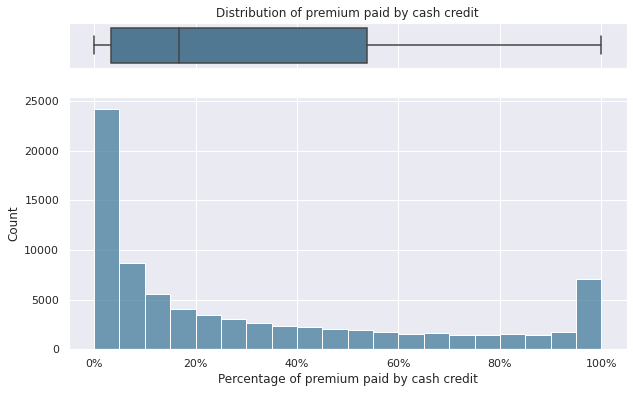

In [ ]:
# Code based from https://www.python-graph-gallery.com/24-histogram-with-a-boxplot-on-top-seaborn 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
sns.set(style="darkgrid")
 
# creating a figure composed of two matplotlib.Axes objects (ax_box and ax_hist)
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(10,6))

# assigning a graph to each ax
sns.boxplot(train["perc_premium_paid_by_cash_credit"], ax=ax_box, palette=["#457b9d"])
sns.histplot(train["perc_premium_paid_by_cash_credit"], ax=ax_hist, bins=20, color="#457b9d")
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='', title='Distribution of premium paid by cash credit')
ax_hist.set(xlabel='Percentage of premium paid by cash credit')
ax_hist.xaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.show()

In [ ]:
print('Percentage of premium paid by cash credit equals to zero:' , round(sum(train["perc_premium_paid_by_cash_credit"]==0)/train.shape[0]*100,2), '%')
print('Percentage of premium paid by cash credit more than 0% and equals to or less than 20%:' , round(sum((train["perc_premium_paid_by_cash_credit"]>0)&(train["perc_premium_paid_by_cash_credit"]<=0.2))/train.shape[0]*100,2), '%')
print('Percentage of premium paid by cash credit equals to 100%:' , round(sum(train["perc_premium_paid_by_cash_credit"]==1)/train.shape[0]*100,2), '%')

Percentage of premium paid by cash credit equals to zero: 7.17 %
Percentage of premium paid by cash credit more than 0% and equals to or less than 20%: 46.14 %
Percentage of premium paid by cash credit equals to 100%: 6.27 %


When comparing the payment on cash credit and the event of payment itself, we can unquestionably see a difference between groups. From the boxplot below, it is noticeable how the percentage of cash credit the low in the group of good payers and is a lot higher on the defaulting policyholder group.

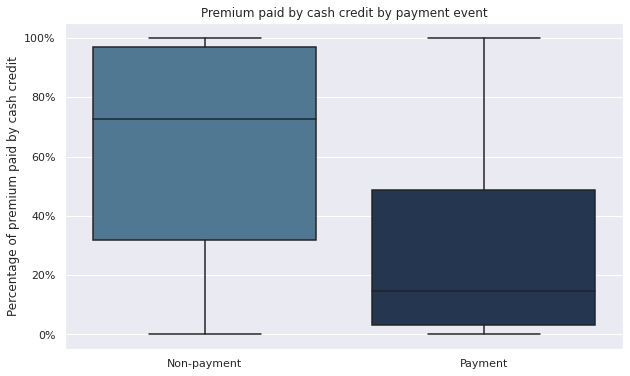

In [ ]:
train['target_text'] = np.where(train['target'] == 0, 'Non-payment', np.where(train['target'] == 1, 'Payment', 'NA'))
train['target_text'] = train['target_text'].astype('category')

fig, ax = plt.subplots(figsize=(10,6))
sns.boxplot(x="target_text", y="perc_premium_paid_by_cash_credit", data=train, palette=["#457b9d", "#1d3557"], ax=ax)
ax.set(xlabel='', ylabel='Percentage of premium paid by cash credit', title='Premium paid by cash credit by payment event')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.show()

Although the difference between the groups is visible from the boxplot, we proceeded to do a statistical test and verify the difference. First, we test the data for normality. Since the data is not normal, we proceed to use the non-parametric Mann-Whitney test, which statistically verifies that the good payers' group has the lowest percentage of payment on cash credit.

Since this variable behaved differently amongst the response variable levels, it probably will be important for our model.

In [ ]:
from scipy import stats
stats.normaltest(train['perc_premium_paid_by_cash_credit'])

NormaltestResult(statistic=10724.382256426286, pvalue=0.0)

In [ ]:
from scipy.stats import mannwhitneyu

# H0: Percentage of premium paid by cash credit in both groups (non-payment and payment) are the same
# H0: Percentage of premium paid by cash credit in the non-payment group greater tha in the payment group

mannwhitneyu(train['perc_premium_paid_by_cash_credit'], train['target'], alternative='less')

MannwhitneyuResult(statistic=572165216.5, pvalue=0.0)

### 2.1.3 Variable: Age in days

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


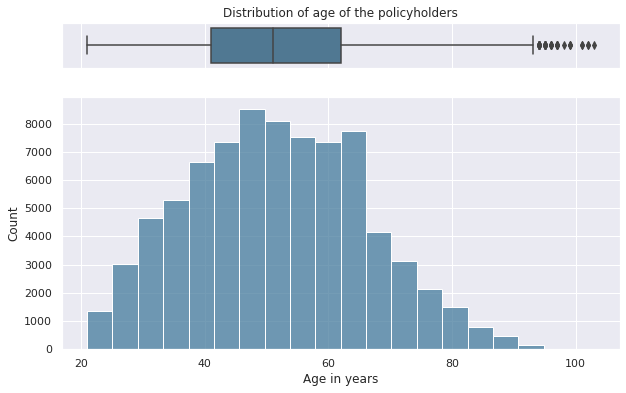

In [ ]:
# creating a figure composed of two matplotlib.Axes objects (ax_box and ax_hist)
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(10,6))

# assigning a graph to each ax
sns.boxplot(train["age_in_days"]/365, ax=ax_box, palette=["#457b9d"])
sns.histplot(train["age_in_days"]/365, ax=ax_hist, bins=20, color="#457b9d")
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='', title='Distribution of age of the policyholders')
ax_hist.set(xlabel='Age in years')
plt.show()

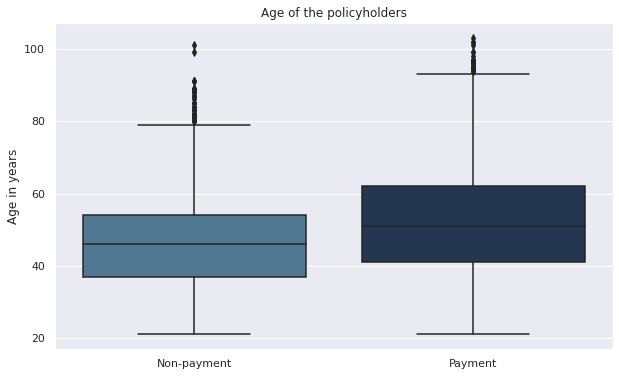

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
sns.boxplot(x=train["target_text"], y=train["age_in_days"]/365, palette=["#457b9d", "#1d3557"], ax=ax)
ax.set(xlabel='', ylabel='Age in years', title='Age of the policyholders')
plt.show()

In [ ]:
stats.normaltest(train['age_in_days'])

NormaltestResult(statistic=1862.9252545682307, pvalue=0.0)

In [ ]:
mannwhitneyu(train['age_in_days'], train['target'])

MannwhitneyuResult(statistic=0.0, pvalue=0.0)

### 2.1.4 Variable: Income


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


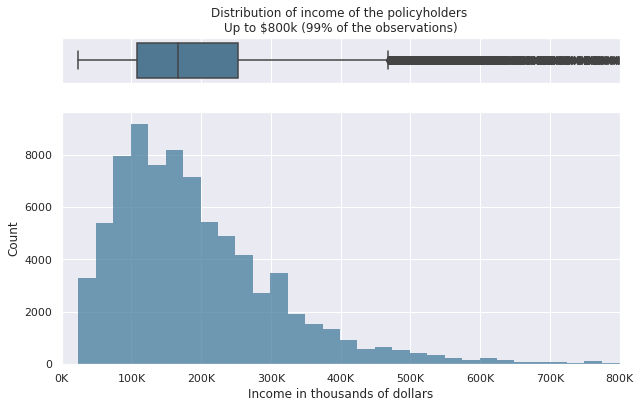

In [ ]:
import matplotlib.ticker as ticker

# creating a figure composed of two matplotlib.Axes objects (ax_box and ax_hist)
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(10,6))

# assigning a graph to each ax
sns.boxplot(train["Income"], ax=ax_box, palette=["#457b9d"])
sns.histplot(train["Income"], ax=ax_hist, binwidth=25000, color="#457b9d")
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='', title='Distribution of income of the policyholders \nUp to $800k (99% of the observations)')
ax_hist.set(xlabel='Income in thousands of dollars', xlim=(0, 800000))
ax_hist.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))

plt.show()

In [ ]:
train['Income'].describe()

count    7.985300e+04
mean     2.088472e+05
std      4.965826e+05
min      2.403000e+04
25%      1.080100e+05
50%      1.665600e+05
75%      2.520900e+05
max      9.026260e+07
Name: Income, dtype: float64

75% of the policyholders have an income up to 252k dollars, while 50% earn between 108k and 252k. This variable is positively skewed, meaning that most values are clustered around the left tail, while few observations are distributed longer on the right tail. Approximately 3.5% of policyholders have an income greater than half a million, 0.6% (498 observations) receive more than a million dollars and the maximum value recorded is greater than 90 million.

The higher values on the left tail are an indication that we should probably perform some feature engineering, such as a log transform.

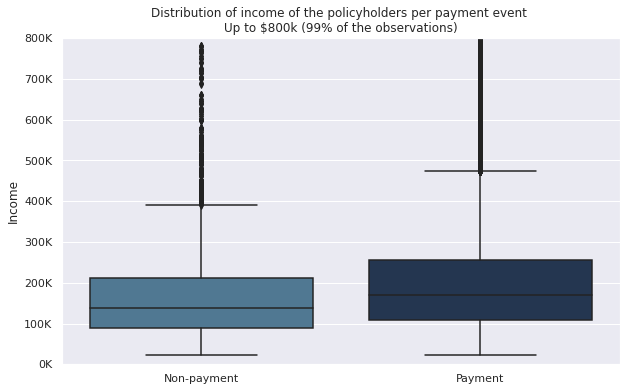

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
sns.boxplot(x=train["target_text"], y=train["Income"], palette=["#457b9d", "#1d3557"], ax=ax)
ax.set(xlabel='', title='Distribution of income of the policyholders per payment event \nUp to $800k (99% of the observations)', ylim=(0, 800000))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))
plt.show()

### 2.1.5 Variable: Count_3-6_months_late

In [ ]:
train['Count_3-6_months_late'].describe()

count    79756.000000
mean         0.248671
std          0.691468
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         13.000000
Name: Count_3-6_months_late, dtype: float64

In [ ]:
train['Count_3-6_months_late'].value_counts()

0.0     66801
1.0      8826
2.0      2519
3.0       954
4.0       374
5.0       168
6.0        68
7.0        23
8.0        15
9.0         4
11.0        1
12.0        1
13.0        1
10.0        1
Name: Count_3-6_months_late, dtype: int64

In [ ]:
print('Count_3-6_months_late equals to 0:' , round(sum(train["Count_3-6_months_late"]==0)/train.shape[0]*100,2), '%')
print('Count_3-6_months_late more than 0 and equals to or less than 3:' , round(sum((train["Count_3-6_months_late"]>0)&(train["Count_3-6_months_late"]<=3))/train.shape[0]*100,2), '%')
print('Count_3-6_months_late bigger than 3:' , round(sum(train["Count_3-6_months_late"]>3)/train.shape[0]*100,2), '%')

Count_3-6_months_late equals to 0: 83.65 %
Count_3-6_months_late more than 0 and equals to or less than 3: 15.4 %
Count_3-6_months_late bigger than 3: 0.82 %


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


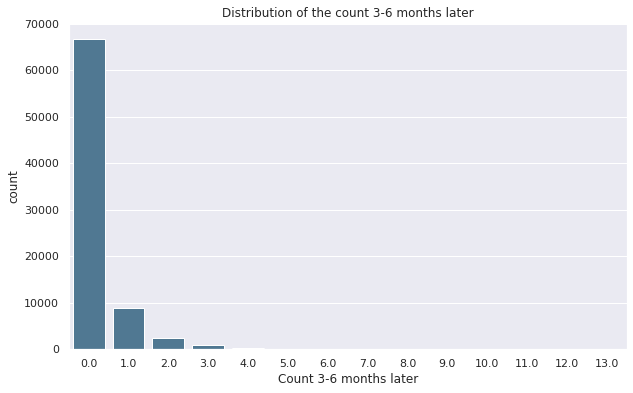

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
sns.countplot(train["Count_3-6_months_late"], ax=ax, color="#457b9d")
ax.set(xlabel='Count 3-6 months later', title='Distribution of the count 3-6 months later')
plt.show()

### 2.1.6 Variable: Count_6-12_months_late

In [ ]:
train['Count_6-12_months_late'].describe()

count    79756.000000
mean         0.078188
std          0.436507
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         17.000000
Name: Count_6-12_months_late, dtype: float64

In [ ]:
train['Count_6-12_months_late'].value_counts()

0.0     75831
1.0      2680
2.0       693
3.0       317
4.0       130
5.0        46
6.0        26
7.0        11
8.0         5
10.0        4
9.0         4
14.0        2
11.0        2
13.0        2
17.0        1
12.0        1
15.0        1
Name: Count_6-12_months_late, dtype: int64

In [ ]:
print('Count_6-12_months_late equals to 0:' , round(sum(train["Count_6-12_months_late"]==0)/train.shape[0]*100,2), '%')
print('Count_6-12_months_late more than 0 and equals to or less than 3:' , round(sum((train["Count_6-12_months_late"]>0)&(train["Count_6-12_months_late"]<=3))/train.shape[0]*100,2), '%')
print('Count_6-12_months_late bigger than 3:' , round(sum(train["Count_6-12_months_late"]>3)/train.shape[0]*100,2), '%')

Count_6-12_months_late equals to 0: 94.96 %
Count_6-12_months_late more than 0 and equals to or less than 3: 4.62 %
Count_6-12_months_late bigger than 3: 0.29 %


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


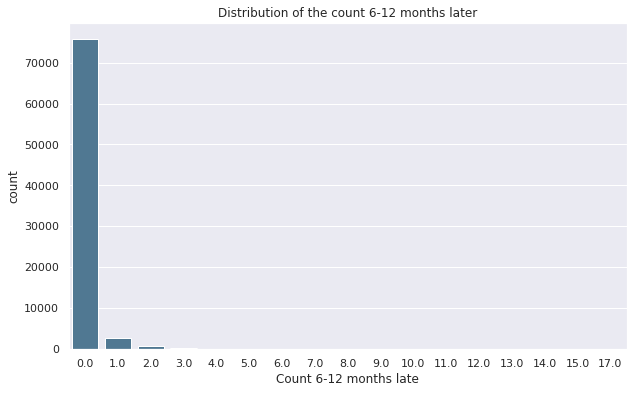

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
sns.countplot(train["Count_6-12_months_late"], ax=ax, color="#457b9d")
ax.set(xlabel='Count 6-12 months late', title='Distribution of the count 6-12 months later')
plt.show()

### 2.1.7 Variable: Count_more_than_12_months_late

In [ ]:
train['Count_more_than_12_months_late'].describe()

count    79756.000000
mean         0.060008
std          0.312023
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         11.000000
Name: Count_more_than_12_months_late, dtype: float64

In [ ]:
train['Count_more_than_12_months_late'].value_counts()

0.0     76038
1.0      2996
2.0       498
3.0       151
4.0        48
5.0        13
6.0         6
7.0         3
8.0         2
11.0        1
Name: Count_more_than_12_months_late, dtype: int64

In [ ]:
print('Count_more_than_12_months_late equals to 0:' , round(sum(train["Count_more_than_12_months_late"]==0)/train.shape[0]*100,2), '%')
print('Count_more_than_12_months_late more than 0 and equals to or less than 3:' , round(sum((train["Count_more_than_12_months_late"]>0)&(train["Count_more_than_12_months_late"]<=3))/train.shape[0]*100,2), '%')
print('Count_more_than_12_months_late bigger than 3:' , round(sum(train["Count_more_than_12_months_late"]>3)/train.shape[0]*100,2), '%')

Count_more_than_12_months_late equals to 0: 95.22 %
Count_more_than_12_months_late more than 0 and equals to or less than 3: 4.56 %
Count_more_than_12_months_late bigger than 3: 0.09 %


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


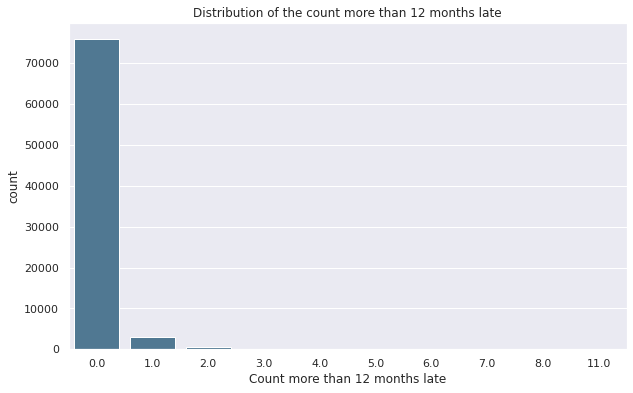

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
sns.countplot(train["Count_more_than_12_months_late"], ax=ax, color="#457b9d")
ax.set(xlabel='Count more than 12 months late', title='Distribution of the count more than 12 months late')
plt.show()

### 2.1.8 Variable: application_underwriting_score

In [ ]:
train['application_underwriting_score'].describe()

count    76879.000000
mean        99.067291
std          0.739799
min         91.900000
25%         98.810000
50%         99.210000
75%         99.540000
max         99.890000
Name: application_underwriting_score, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


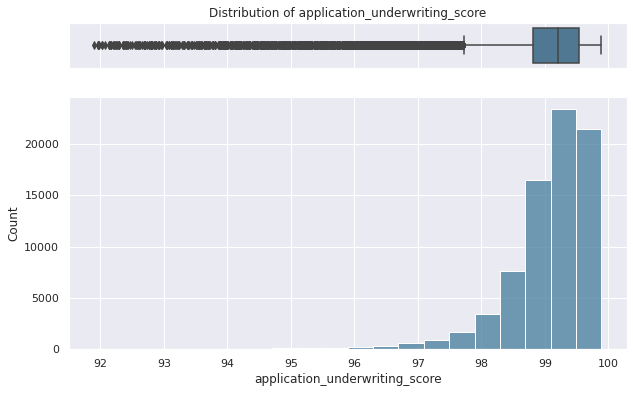

In [ ]:
# creating a figure composed of two matplotlib.Axes objects (ax_box and ax_hist)
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(10,6))

# assigning a graph to each ax
sns.boxplot(train["application_underwriting_score"], ax=ax_box, palette=["#457b9d"])
sns.histplot(train["application_underwriting_score"], ax=ax_hist, bins=20, color="#457b9d")
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='', title='Distribution of application_underwriting_score')
ax_hist.set(xlabel='application_underwriting_score')
plt.show()

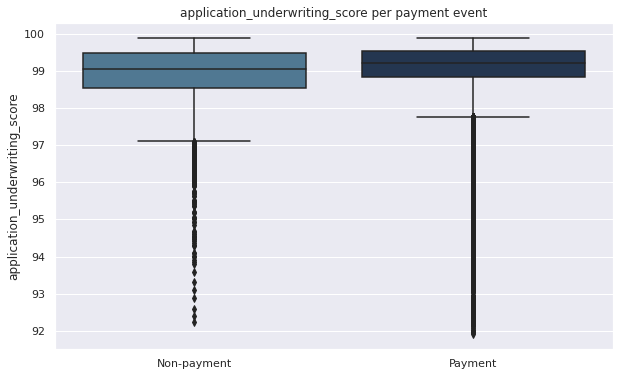

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
sns.boxplot(x=train["target_text"], y=train["application_underwriting_score"], palette=["#457b9d", "#1d3557"], ax=ax)
ax.set(xlabel='', ylabel='application_underwriting_score', title='application_underwriting_score per payment event')
plt.show()

### 2.1.9 Variable: no_of_premiums_paid

In [ ]:
train['no_of_premiums_paid'].describe()

count    79853.000000
mean        10.863887
std          5.170687
min          2.000000
25%          7.000000
50%         10.000000
75%         14.000000
max         60.000000
Name: no_of_premiums_paid, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


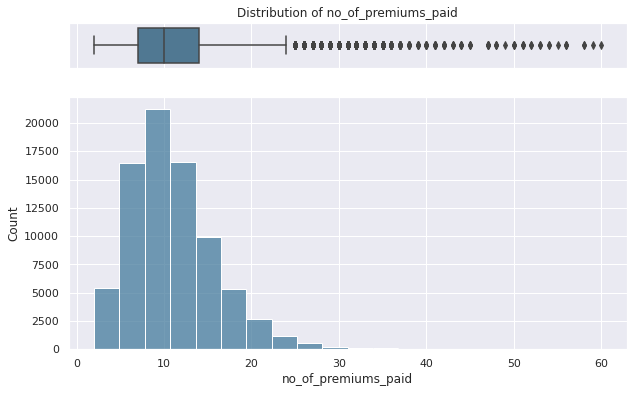

In [ ]:
# creating a figure composed of two matplotlib.Axes objects (ax_box and ax_hist)
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(10,6))

# assigning a graph to each ax
sns.boxplot(train["no_of_premiums_paid"], ax=ax_box, palette=["#457b9d"])
sns.histplot(train["no_of_premiums_paid"], ax=ax_hist, bins=20, color="#457b9d")
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='', title='Distribution of no_of_premiums_paid')
ax_hist.set(xlabel='no_of_premiums_paid')
plt.show()

### 2.1.10 Variable: sourcing_channel

In [ ]:
train['sourcing_channel'].value_counts()

A    43134
B    16512
C    12039
D     7559
E      609
Name: sourcing_channel, dtype: int64

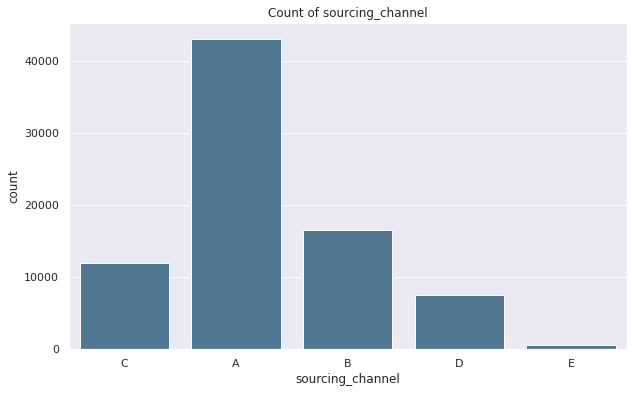

In [108]:
fig, ax = plt.subplots(figsize=(10,6))
sns.countplot(x=train["sourcing_channel"], ax=ax, color="#457b9d")
ax.set(xlabel='sourcing_channel', title='Count of sourcing_channel')
plt.show()

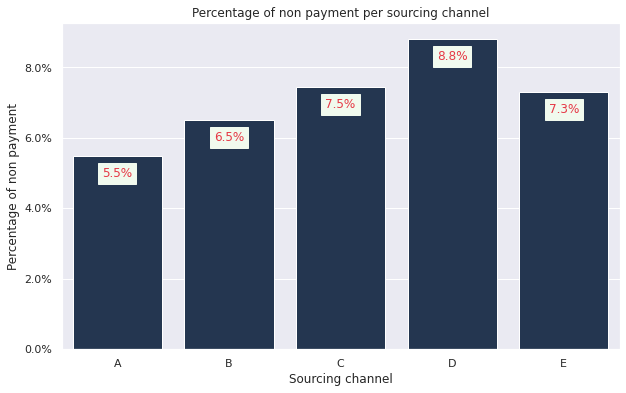

In [183]:
# Adapted from https://www.python-graph-gallery.com/stacked-and-percent-stacked-barplot
import matplotlib.patches as mpatches

# set the figure size
plt.figure(figsize=(10, 6))

# from raw value to percentage
total = train.groupby('sourcing_channel')['id'].sum().reset_index()
payment = train[train.target_text!='Payment'].groupby('sourcing_channel')['id'].sum().reset_index()
payment['total_payment'] = [i / j * 100 for i,j in zip(payment['id'], total['id'])]
total['total_payment'] = [i / j * 100 for i,j in zip(total['id'], total['id'])]

# bar chart 1 -> top bars (group of 'Payment=Yes')
#bar1 = sns.barplot(x="sourcing_channel",  y="total_payment", data=total, color='#457b9d')

# bar chart 2 -> bottom bars (group of 'Payment=No')
bar2 = sns.barplot(x="sourcing_channel", y="total_payment", data=payment, color='#1d3557')

# add labels
for p in bar2.patches:
 # get the height of each bar
 height = p.get_height()
 # adding text to each bar
 bar2.text(x = p.get_x()+(p.get_width()/2), # x-coordinate position of data label, padded to be in the middle of the bar
 y = height-0.6, # y-coordinate position of data label, padded 0.6 below bar
 s = '{:.1f}%'.format(height), # data label, formatted to ignore decimals
 ha = 'center', # sets horizontal alignment (ha) to center
 color = '#e63946').set_backgroundcolor('#f1faee')

# add legend
#top_bar = mpatches.Patch(color='#1d3557', label='Payment = No')
#bottom_bar = mpatches.Patch(color='#457b9d', label='Payment = Yes')
#plt.legend( loc='upper left', handles=[top_bar, bottom_bar])

bar2.yaxis.set_major_formatter(mtick.PercentFormatter())
bar2.set(xlabel='Sourcing channel', ylabel='Percentage of non payment', title='Percentage of non payment per sourcing channel')

# show the graph
plt.show()

### 2.1.11 Variable: residence_area_type

In [177]:
train['residence_area_type'].value_counts()

Urban    48183
Rural    31670
Name: residence_area_type, dtype: int64

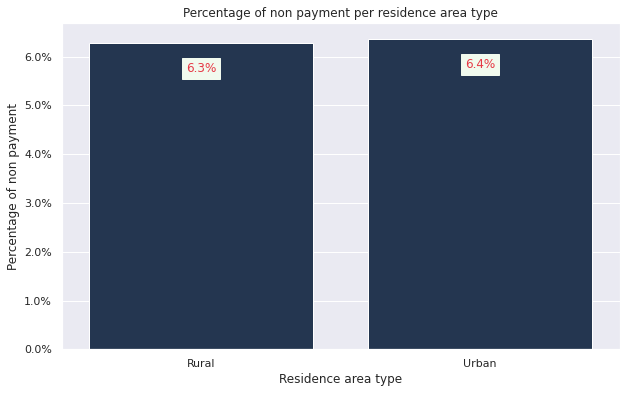

In [184]:
# set the figure size
plt.figure(figsize=(10, 6))

# from raw value to percentage
total = train.groupby('residence_area_type')['id'].sum().reset_index()
payment = train[train.target_text!='Payment'].groupby('residence_area_type')['id'].sum().reset_index()
payment['total_payment'] = [i / j * 100 for i,j in zip(payment['id'], total['id'])]
total['total_payment'] = [i / j * 100 for i,j in zip(total['id'], total['id'])]

# bar chart 1 -> top bars (group of 'Payment=Yes')
#bar1 = sns.barplot(x="residence_area_type",  y="total_payment", data=total, color='#457b9d')

# bar chart 2 -> bottom bars (group of 'Payment=No')
bar2 = sns.barplot(x="residence_area_type", y="total_payment", data=payment, color='#1d3557')

# add labels
for p in bar2.patches:
 # get the height of each bar
 height = p.get_height()
 # adding text to each bar
 bar2.text(x = p.get_x()+(p.get_width()/2), # x-coordinate position of data label, padded to be in the middle of the bar
 y = height-0.6, # y-coordinate position of data label, padded 0.6 below bar
 s = '{:.1f}%'.format(height), # data label, formatted to ignore decimals
 ha = 'center', # sets horizontal alignment (ha) to center
 color = '#e63946').set_backgroundcolor('#f1faee')

# add legend
#top_bar = mpatches.Patch(color='#1d3557', label='Payment = No')
#bottom_bar = mpatches.Patch(color='#457b9d', label='Payment = Yes')
#plt.legend( loc='upper left', handles=[top_bar, bottom_bar])

bar2.yaxis.set_major_formatter(mtick.PercentFormatter())
bar2.set(xlabel='Residence area type', ylabel='Percentage of non payment', title='Percentage of non payment per residence area type')

# show the graph
plt.show()

### 2.1.12 Variable: premium

In [ ]:
train['premium'].describe()

count    79853.000000
mean     10924.507533
std       9401.676542
min       1200.000000
25%       5400.000000
50%       7500.000000
75%      13800.000000
max      60000.000000
Name: premium, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


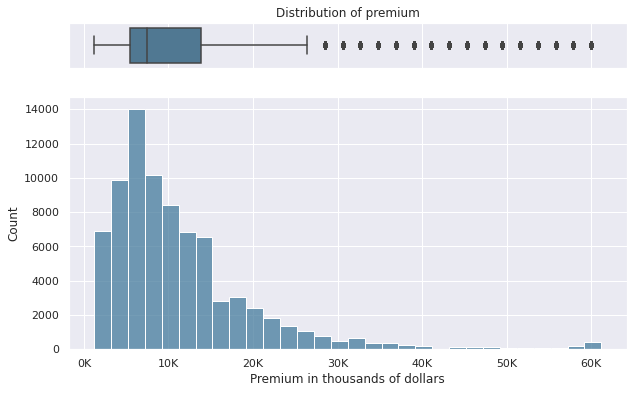

In [ ]:
# creating a figure composed of two matplotlib.Axes objects (ax_box and ax_hist)
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(10,6))

# assigning a graph to each ax
sns.boxplot(train["premium"], ax=ax_box, palette=["#457b9d"])
sns.histplot(train["premium"], ax=ax_hist, binwidth=2000, color="#457b9d")
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='', title='Distribution of premium')
ax_hist.set(xlabel='Premium in thousands of dollars')
ax_hist.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))

plt.show()

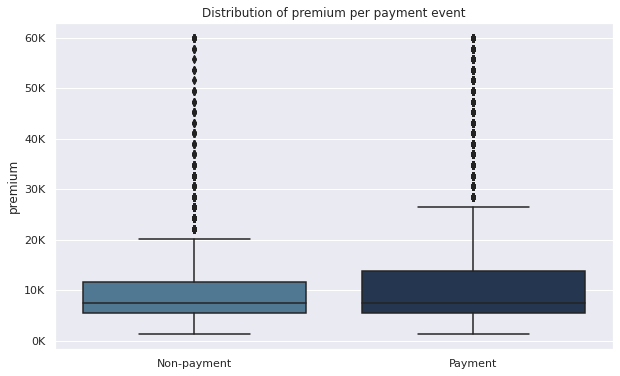

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
sns.boxplot(x=train["target_text"], y=train["premium"], palette=["#457b9d", "#1d3557"], ax=ax)
ax.set(xlabel='', title='Distribution of premium per payment event')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))
plt.show()

### 2.1.12 Variable: Correlations

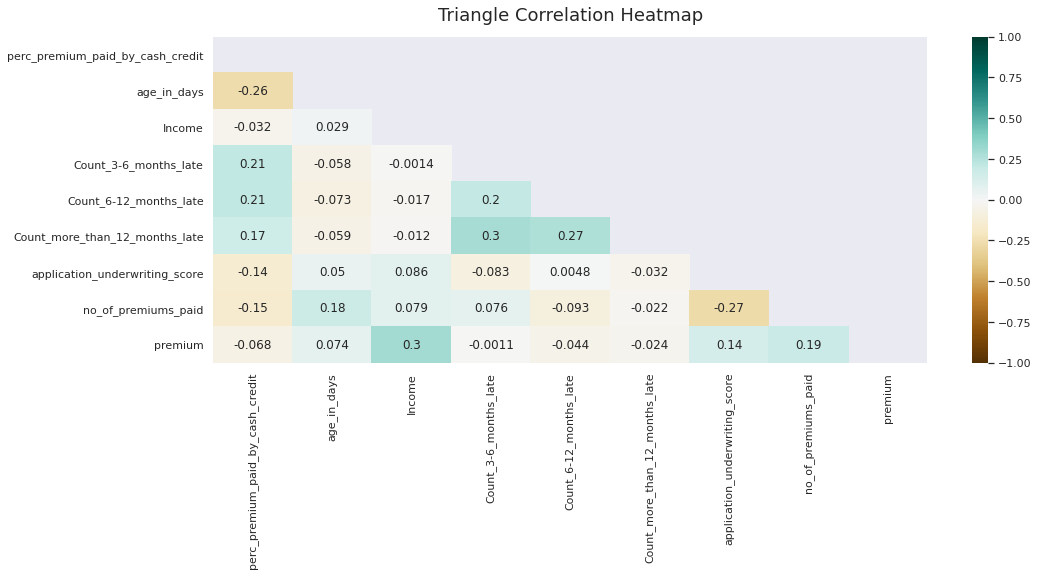

In [ ]:
# based on https://medium.com/@szabo.bibor/how-to-create-a-seaborn-correlation-heatmap-in-python-834c0686b88e

train_corr = train.loc[:, ~train.columns.isin(['id', 'target'])]

plt.figure(figsize=(16, 6))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(train_corr.corr(), dtype=np.bool))
heatmap = sns.heatmap(train_corr.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

# References

[1] https://www.kaggle.com/itssuru/health-insurance-premium-of-customers

[2] https://www.f1-predictor.com/building-an-f1-prediction-engine-feature-engineering-part-i/](https://www.f1-predictor.com/building-an-f1-prediction-engine-feature-engineering-part-i/

[3] https://www.amfam.com/resources/articles/understanding-insurance/basic-insurance-terms-and-definitions

[4] 